In [5]:
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
import pandas as pd
import numpy as np
import scipy as sp
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
import seaborn as sns
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier

import kinesis as kn
import gapipes as gp

In [11]:
Vizier.ROW_LIMIT = -1   # query the entire catalog

# Cantat-Gaudin2019
original = Vizier.get_catalogs("J/A+A/626/A17")[0]

In [17]:
original[:3]

RA_ICRS,DE_ICRS,Source,Plx,pmRA,pmDE,Gmag,BPmag,RPmag,BP-RP,RV,Prob,X,Y,Z,Pop,_RA.icrs,_DE.icrs
deg,deg,,mas,mas / yr,mas / yr,mag,mag,mag,mag,km / s,,pc,pc,pc,,deg,deg
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,uint8,float64,float64
134.23483232489099,-52.018017978003300,5323770984573837952,1.8695433046610599,-11.8383283592489992,10.2508919696444991,16.1572590,17.1580770,15.1583800,1.9996977,--,0.58999999999999997,-2.424564,-525.162357,-39.082,1,134.23491514826000,-52.018062113759100
132.12813846002800,-50.501289379279903,5327807223033954560,2.0036062280529801,-12.5864882300014003,9.9565231752849304,17.9356920,19.4035500,16.7464200,2.6571293,--,0.56000000000000005,15.511423,-490.532648,-36.919,1,132.12822365922401,-50.501332247612503
132.23734508272699,-47.131631392836297,5329515451797653504,1.9767949368642901,-12.1018534745413007,10.7664000222310001,11.8132990,12.0949150,11.3830900,0.7118254,17.080925230010599591,0.95999999999999996,38.026797,-497.305191,-18.508,1,132.23742167246101,-47.131677748144199


In [14]:
table_fulldr2 = gp.gaia.query_sourceid(original[['Source']], 'Source')

In [15]:
assert set(table_fulldr2['source_id']) == set(original['Source'])

In [19]:
ct2019_columns = ["Prob", "Pop"]
table_fulldr2_ct2019 = table_fulldr2.merge(
    original[["Source"] + ct2019_columns]
    .to_pandas()
    .rename(columns={"Source": "source_id"}),
    on="source_id",
)

In [21]:
table_fulldr2_ct2019['Pop'].value_counts().sort_index()

1     185
2    2390
3     879
4    3961
5     431
6     782
7    3215
Name: Pop, dtype: int64

In [22]:
grp = table_fulldr2_ct2019.groupby('Pop')
srcdf = grp.get_group(7)

In [28]:
necessary_columns = [
    "ra",
    "dec",
    "phot_g_mean_mag",
    "parallax",
    "pmra",
    "pmdec",
    "parallax_error",
    "pmra_error",
    "pmdec_error",
    "parallax_pmra_corr",
    "parallax_pmdec_corr",
    "pmra_pmdec_corr",
]
data = srcdf[
    necessary_columns + ["radial_velocity", "radial_velocity_error"]
].copy()
b0 = data.g.icrs.cartesian.xyz.value.mean(axis=1)
print(f"{len(data)} rows")
print(f"b0 = {b0}")

N = len(data)
irv = np.arange(N)[data["radial_velocity"].notna()]
rv = data["radial_velocity"].values[irv]
rv_error = data["radial_velocity_error"].values[irv]
data_dict = {
    "N": N,
    "Nrv": data["radial_velocity"].notna().sum(),
    "ra": data["ra"].values,
    "dec": data["dec"].values,
    "a": data[["parallax", "pmra", "pmdec"]].values,
    "C": data.g.make_cov(),
    "irv": irv,
    "rv": rv,
    "rv_error": rv_error,
    "include_T": 1,
    "b0": b0,
}

def stan_init():
    return dict(
        d=1e3 / data["parallax"].values,
        sigv=[0.5, 0.5, 0.5],
        Omega=np.eye(3),
        v0=[-5, 45, -5],
        T=np.zeros(shape=(1, 3, 3)),
        v0_bg=[0, 0, 0],
        sigv_bg=50.0,
        f_mem=0.95,
    )

stanmodel = kn.get_model("allcombined")
fit = stanmodel.optimizing(
    data=data_dict,
    init=stan_init,
#     pars=[
#         "v0",
#         "sigv",
#         "Omega",
#         "T_param",
#         "v0_bg",
#         "sigv_bg",
#         "f_mem",
#         "probmem",
#         "a_model",
#         "rv_model",
#     ],
)
# kn.save_stanfit(fit, outfile)

INFO:kinesis.models:Reading model from disk


3215 rows
b0 = [-137.31710115  226.26638412 -270.67434907]


In [50]:
fit['v0']

array([-3.96219368, 27.20013532, -2.79674747])

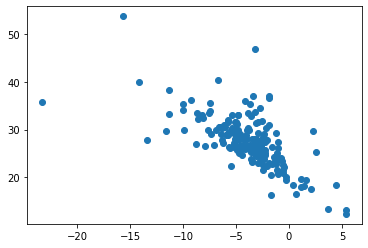

In [54]:
vxyz = srcdf.g.icrs.velocity.d_xyz.value
xyz = srcdf.g.icrs.cartesian.xyz.value
plt.scatter(vxyz[0],vxyz[1])

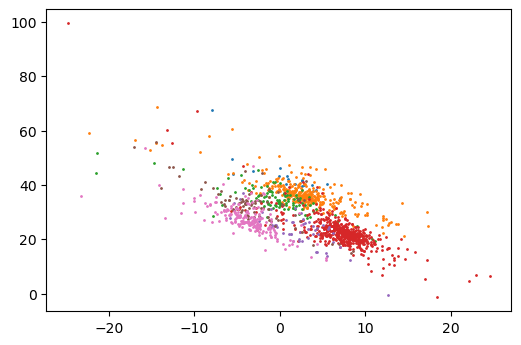

In [58]:
fig, ax = plt.subplots(dpi=100)
for l, g in grp:
    vxyz = g.g.icrs.velocity.d_xyz.value

    ax.scatter(vxyz[0],vxyz[1], s=1)